In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import os
import sys
sys.path.append('../')

# Load Student Data

In [2]:
from src.d01_data.student_data_api import StudentDataApi

def isFocal(row):
    return (row['FRL'] + row['AALPI']) > 1

student_data_file = "/share/data/school_choice_equity/simulator_data/student/drop_optout_{}.csv"
period = "1819"
student_df = pd.read_csv(student_data_file.format(period)).set_index('studentno')
# mask = student_df['grade'] == 'KG'
# student_df = student_df.loc[mask]
student_df['focal'] = student_df.apply(lambda row: isFocal(row), axis=1).astype('int64')

student_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,Unnamed: 0.1.1.1,r1_ranked_idschool,r1_listed_ranks,r1_programs,grade,r1_randomnumber,...,currentlp,msf,aaprek,aa,AALPI,FRL,knapsack008,pc1002_050,naive004,focal
studentno,,,,,,,,,,,,,,,,,,,,,
10210005,0,0,0,2085,6222,"[435, 670]","[1, 2]","['GE', 'GE']",KG,"[0.9110051502117931, 0.111640986769763]",...,NaN,NaN,NaN,[670],1,1,0.0,1.0,0.0,1
10210006,1,1,1,2086,6223,"[729, 537, 680, 876, 729]","[1, 2, 3, 4, 5]","['SE', 'SE', 'SE', 'CE', 'GE']",KG,"[0.41175899240252206, 0.33197490658210305, 0.0...",...,NaN,NaN,NaN,NaN,0,0,0.0,1.0,0.0,0
10210007,2,2,2,2087,6224,"[786, 569, 735, 435, 549, 413, 589, 479, 718, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","['JE', 'GE', 'GE', 'GE', 'GE', 'GE', 'GE', 'GE...",KG,"[0.9240686684326509, 0.591082980668961, 0.3187...",...,NaN,NaN,NaN,[735],0,0,0.0,0.0,0.0,0
10210010,3,3,3,2088,6225,"[796, 420, 505, 722, 589, 618, 876, 718, 493, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","['GE', 'SE', 'GE', 'GE', 'GE', 'SE', 'CE', 'GE...",KG,"[0.0774816984940387, 0.826669827283934, 0.8127...",...,NaN,NaN,NaN,[505],1,1,0.0,0.0,0.0,1
10210039,4,4,4,2090,6227,"[537, 680, 691, 729, 493, 593, 820, 420]","[1, 2, 3, 4, 5, 6, 7, 8]","['SN', 'SN', 'SB', 'SN', 'GE', 'SB', 'GE', 'SN']",KG,"[0.6978629528767499, 0.26137276100872897, 0.29...",...,NaN,NaN,NaN,[820],1,1,1.0,1.0,0.0,1


# Load Assignment Results

In [12]:
diversity_category_col = 'Diversity_Category3'  # diversity category column
program_cutoff = 'program_cutoff'  # program cutoff column (in points)
cutoff_tiebreaker = 'cutoff_tiebreaker'  # the cutoff tiebreaker of the program to which the student was assigned
focal_block = 'focal_block'  # if students gets equity tiebreaker
tiebreaker_status = 'status'  # if student counts as TP, TN, FP or FN

def get_specific_program_cutoff(x, diversity_category):
    if isinstance(x, float):
        return x
    x_list = x[1:-1].split()
    return float(x_list[diversity_category])

def check_tiebreaker(row):
    if diversity_category_col in row.index:
        diversity_category = row[diversity_category_col]
        cut_off = get_specific_program_cutoff(row[program_cutoff], diversity_category)
    else:
        cut_off = row[program_cutoff]
        
    if cut_off > 4:
        return "sibiling"
    elif cut_off > 3:
        return "equity+zone"
    elif cut_off > 2 :
        return "equity"
    elif cut_off > 1:
        return "zone"
    elif cut_off > 0:
        return "lottery"
    else:
        return "none"
    
def q1(x):
    return np.quantile(x, .25)
def q2(x):
    return np.quantile(x, .5)
def q3(x):
    return np.quantile(x, .75)

def augment_assigment(assignment_df, equity_tiebreaker):
    if equity_tiebreaker == 'none':
        student_df[equity_tiebreaker] = 0.
    elif equity_tiebreaker == 'test':
        student_df[equity_tiebreaker] = student_df['ctip1']
    assignment_df[cutoff_tiebreaker] = assignment_df.apply(lambda row: check_tiebreaker(row), axis=1, raw=False)
    assignment_df[focal_block] = student_df[equity_tiebreaker].reindex(assignment_df.index)
    assignment_df['focal'] = student_df['focal'].reindex(assignment_df.index)
    get_student_tiebreaker_status(assignment_df)
    
def get_student_tiebreaker_status(df):
    mask_focal = df['focal'] == 1
    mask_focal_block = df[focal_block] == 1
    df[tiebreaker_status] = "TN"
    df.at[mask_focal & mask_focal_block, tiebreaker_status] = "TP"
    df.at[~mask_focal & mask_focal_block, tiebreaker_status] = "FP"
    df.at[mask_focal & ~mask_focal_block, tiebreaker_status] = "FN"
   

In [59]:
assignments_dir = "/share/data/school_choice_equity/local_runs/Assignments/"
# assignments_dir = "/share/data/school_choice_equity/temp/Assignments/"

def get_filename_template(policy, guard_rails):
    if policy == "Con1":
        if guard_rails == 0:
            return "Assignment_{}_CTIP1_round_merged123_policyCon1GuardRails0-RealPref_tiesSTB_prefExtend0_iteration{}.csv"
        else:
            return "Assignment_{}_CTIP1_round_merged123_policyCon1-RealPref_tiesSTB_prefExtend0_iteration{}.csv"
    elif policy == "Medium1":
        if guard_rails == 0:
            return "Assignment_{}_CTIP1_round_merged123_policyMedium1GuardRails0-RealPref_tiesSTB_prefExtend0_iteration{}.csv"
        else:
            return "Assignment_{}_CTIP1_round_merged123_policyMedium1-RealPref_tiesSTB_prefExtend0_iteration{}.csv"
    

equity_tiebreaker_list = ['none', 'ctip1', 'knapsack008', 'pc1002_050', 'naive004']
num_iterations = 20
policy = "Medium1"
guard_rails = 0
filename_template = get_filename_template(policy, guard_rails)

# Assignment Summary

Get sum summary statistics by grouping by Diversity Category, Focal and Cutoff Tiebreaker (Program Cutoff). The summary statistics are counts, mean, min, Q1, Q2 (median), Q3 and max.

In [4]:
def get_summary_iteration(assignment_df, equity_tiebreaker):
    augment_assigment(assignment_df, equity_tiebreaker)
    evaluation_columns = [diversity_category_col, 'rank', 'designation', 'In-Zone Rank', 
    # evaluation_columns = ['rank', 'designation', 'In-Zone Rank', 
                          cutoff_tiebreaker, equity_tiebreaker, 'focal', 'iteration']

    group_columns = [diversity_category_col, 'focal']
    
    rank_funs = ['count','mean', 'min', q1, q2, q3, 'max']
    
    return assignment_df[evaluation_columns].groupby(group_columns).agg({'rank': rank_funs,
                                                                         equity_tiebreaker: 'mean'})

In [6]:
assignment_dict = dict()
summary_dict = dict()
for equity_tiebreaker in equity_tiebreaker_list:
    summary_df = []
    for iteration in range(num_iterations):
        filename = filename_template.format(equity_tiebreaker, iteration)
        assignment_df = pd.read_csv(assignments_dir+filename).set_index('studentno')
        assignment_df['iteration'] = iteration
        summary_df += [get_summary_iteration(assignment_df, equity_tiebreaker)]

    group_columns = [diversity_category_col, 'focal', 'tiebreaker']
    summary_df = pd.concat(summary_df, axis=0)
    
    summary_dict[equity_tiebreaker] = summary_df

In [7]:
display(HTML("<h3>Results grouped by focal</h3>" ))
for equity_tiebreaker in equity_tiebreaker_list:
    summary_df = summary_dict[equity_tiebreaker]
    display(HTML("<h4>Tiebreaker: %s</h4>" % equity_tiebreaker))
    display(summary_df)

rank                                     none
                          count      mean  min   q1   q2   q3   max mean
Diversity_Category3 focal                                               
0                   0      1461  7.515400  1.0  1.0  3.0  9.0  84.0  0.0
                    1       134  4.873134  1.0  1.0  2.0  6.0  40.0  0.0
1                   0      1328  3.352410  1.0  1.0  2.0  4.0  63.0  0.0
                    1       267  2.337079  1.0  1.0  1.0  3.0  17.0  0.0
2                   0       950  3.178947  1.0  1.0  2.0  3.0  46.0  0.0
...                         ...       ...  ...  ...  ...  ...   ...  ...
0                   1       134  5.440299  1.0  1.0  3.0  7.0  49.0  0.0
1                   0      1328  3.278614  1.0  1.0  2.0  4.0  53.0  0.0
                    1       267  2.662921  1.0  1.0  2.0  3.0  21.0  0.0
2                   0       950  3.001053  1.0  1.0  2.0  3.0  39.0  0.0
                    1       632  2.216772  1.0  1.0  2.0  3.0  15.0  0.0

[120 rows x 8 columns]

rank                                          ctip1
                          count      mean  min   q1   q2    q3   max      mean
Diversity_Category3 focal                                                     
0                   0      1461  7.444216  1.0  1.0  3.0  9.00  77.0  0.004135
                    1       134  4.835821  1.0  1.0  2.0  6.00  45.0  0.007463
1                   0      1328  3.395331  1.0  1.0  2.0  4.00  63.0  0.009893
                    1       267  2.644195  1.0  1.0  2.0  3.00  20.0  0.026820
2                   0       950  3.081053  1.0  1.0  2.0  3.00  46.0  0.366775
...                         ...       ...  ...  ...  ...   ...   ...       ...
0                   1       134  5.104478  1.0  1.0  2.0  6.75  49.0  0.007463
1                   0      1328  3.387048  1.0  1.0  2.0  4.00  52.0  0.009893
                    1       267  2.550562  1.0  1.0  2.0  3.00  20.0  0.026820
2                   0       950  3.073684  1.0  1.0  2.0  3.00  52.0  0.366775
                    1       632  2.188291  1.0  1.0  1.0  2.00  18.0  0.584175

[120 rows x 8 columns]

rank                                       \
                          count      mean  min   q1   q2    q3   max   
Diversity_Category3 focal                                              
0                   0      1461  7.529774  1.0  1.0  3.0  9.00  84.0   
                    1       134  5.873134  1.0  1.0  3.0  7.75  49.0   
1                   0      1328  3.210090  1.0  1.0  2.0  4.00  59.0   
                    1       267  2.449438  1.0  1.0  2.0  2.00  17.0   
2                   0       950  3.189474  1.0  1.0  2.0  3.75  65.0   
...                         ...       ...  ...  ...  ...   ...   ...   
0                   1       134  6.097015  1.0  1.0  3.0  7.75  54.0   
1                   0      1328  3.352410  1.0  1.0  2.0  4.00  83.0   
                    1       267  2.595506  1.0  1.0  2.0  3.00  35.0   
2                   0       950  3.292632  1.0  1.0  2.0  3.00  59.0   
                    1       632  2.178797  1.0  1.0  1.0  2.00  32.0   

                          knapsack008  
                                 mean  
Diversity_Category3 focal              
0                   0        0.010267  
                    1        0.014925  
1                   0        0.181467  
                    1        0.224719  
2                   0        0.552632  
...                               ...  
0                   1        0.014925  
1                   0        0.181467  
                    1        0.224719  
2                   0        0.552632  
                    1        0.759494  

[120 rows x 8 columns]

rank                                     pc1002_050
                          count      mean  min   q1   q2   q3   max       mean
Diversity_Category3 focal                                                     
0                   0      1461  7.552361  1.0  1.0  3.0  9.0  84.0   0.056126
                    1       134  5.529851  1.0  1.0  2.5  6.0  62.0   0.082090
1                   0      1328  3.439759  1.0  1.0  2.0  4.0  83.0   0.591506
                    1       267  2.565543  1.0  1.0  1.0  3.0  35.0   0.782772
2                   0       950  3.061053  1.0  1.0  2.0  3.0  45.0   0.962105
...                         ...       ...  ...  ...  ...  ...   ...        ...
0                   1       134  4.753731  1.0  1.0  3.0  6.0  47.0   0.082090
1                   0      1328  3.530120  1.0  1.0  2.0  4.0  74.0   0.591506
                    1       267  2.292135  1.0  1.0  1.0  2.0  18.0   0.782772
2                   0       950  3.028421  1.0  1.0  2.0  3.0  51.0   0.962105
                    1       632  2.140823  1.0  1.0  1.0  2.0  11.0   0.995253

[120 rows x 8 columns]

# Individual Rank Data

In [55]:
def get_rank_iteration(assignment_df, equity_tiebreaker):
    augment_assigment(assignment_df, equity_tiebreaker)
    assignment_df['iteration'] = iteration
    assignment_df['method'] = equity_tiebreaker
    
    return assignment_df[['iteration', diversity_category_col, 'focal', 'cutoff_tiebreaker', 'rank', 'method', focal_block, tiebreaker_status]]
    # return assignment_df[['iteration', 'focal', 'tiebreaker', 'rank', 'method']]
    

In [60]:
rank_results_df = []
for equity_tiebreaker in equity_tiebreaker_list:
    for iteration in range(num_iterations):
        filename = filename_template.format(equity_tiebreaker, iteration)
        # filename = filename_template.format(iteration)
        assignment_df = pd.read_csv(assignments_dir+filename).set_index('studentno')
        # assignment_df = pd.read_csv("~/local-runs/Assignments/Assignment_CTIP1_round_merged123_policyCon1-noRestrict-LengthByEthn_tiesSTB_prefExtend0_iteration0.csv").set_index('studentno')
        rank_results_df += [get_rank_iteration(assignment_df, equity_tiebreaker).reset_index()]

rank_results_df = pd.concat(rank_results_df, axis=0)
rank_results_df.head()

,studentno,iteration,Diversity_Category3,focal,cutoff_tiebreaker,rank,method,focal_block,status
0,10210005,0,1,1,none,2.0,none,0.0,FN
1,10210006,0,1,0,zone,1.0,none,0.0,TN
2,10210007,0,0,0,none,43.0,none,0.0,TN
3,10210010,0,0,1,zone,1.0,none,0.0,FN
4,10210039,0,2,1,zone,7.0,none,0.0,FN


In [57]:
from src.d00_utils.utils import get_group_value

def get_improvement_over_none(df, equity_tiebreaker_list):
    df = df.groupby(['method', 'studentno']).agg({'rank':'mean', tiebreaker_status: get_group_value})
    df_none = df.loc['none']
    df['change'] = np.nan
    for equity_tiebreaker in equity_tiebreaker_list:
        if equity_tiebreaker == 'none':
            pass
        df.loc[equity_tiebreaker, 'change'] = (df.loc[equity_tiebreaker]['rank'] - df_none['rank']).values
    return df.reset_index()

def get_improvement_tp(df, equity_tiebreaker_list):
    df = df.groupby(['method', 'studentno']).agg({'rank':'mean', tiebreaker_status: get_group_value})
    df_none = df.loc['none']
    new_rows = []
    for equity_tiebreaker in equity_tiebreaker_list:
        if equity_tiebreaker == 'none':
            pass
        df_eqtb = df.loc[equity_tiebreaker]
        mask = df_eqtb[tiebreaker_status] == "TP"
        method_rows = df_eqtb.loc[mask, ['rank']].copy()
        method_rows['method'] = equity_tiebreaker
        method_rows['label'] = "with tiebreaker"
        none_rows = df_none.loc[method_rows.index, ['rank']].copy()
        none_rows['method'] = equity_tiebreaker
        none_rows['label'] = "without tiebreaker"
        
        new_rows += [method_rows.reset_index()] + [none_rows.reset_index()]
    return pd.concat(new_rows, axis=0)
        

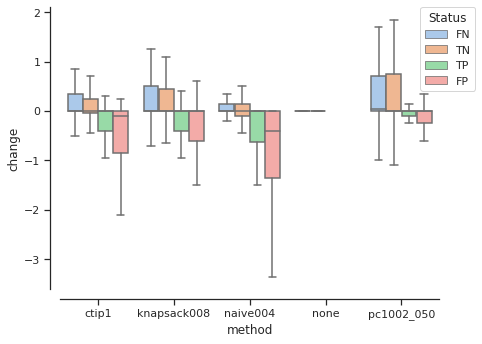

mean  median  count       std
method      status                                   
ctip1       FN      0.279277    0.00    678  0.977397
            FP     -0.737604   -0.10    359  1.383681
            TN      0.119334    0.00   3380  1.911579
            TP     -0.395352    0.00    355  0.829709
knapsack008 FN      0.475153    0.00    491  1.420378
            FP     -0.697484    0.00    775  1.628155
            TN      0.297706    0.00   2964  2.094223
            TP     -0.372048    0.00    542  0.802479
naive004    FN      0.145173    0.00    839  0.773971
            FP     -1.315217   -0.40    115  2.506143
            TN      0.038342    0.00   3624  1.659655
            TP     -0.513918    0.00    194  1.060361
none        FN      0.000000    0.00   1033  0.000000
            TN      0.000000    0.00   3739  0.000000
pc1002_050  FN      0.579076    0.05    184  1.801702
            FP     -0.548751    0.00   1762  2.465173
            TN      0.688037    0.00   1977  2.983682
            TP     -0.198881    0.00    849  1.088096

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="pastel")

# for equity_tiebreaker in equity_tiebreaker_list:
    # display(HTML("<h3>Tiebreaker: %s</h3>" % equity_tiebreaker))
    # mask = rank_results_df['method'] == equity_tiebreaker
df_change = get_improvement_over_none(rank_results_df, equity_tiebreaker_list)
fig, ax = plt.subplots(figsize=(6.8,5.2))
sns.boxplot(ax=ax, x="method", y="change",
            hue=tiebreaker_status,
            data=df_change,
            showfliers = False)
sns.despine(offset=10, trim=False)
plt.legend(bbox_to_anchor=(.95, 1), loc=2, borderaxespad=0., title='Status')
plt.savefig('outputs/boxplot_simulations_change.png')
plt.show()

display(df_change.groupby(['method', tiebreaker_status])['change'].agg(['mean', 'median', 'count', 'std']))

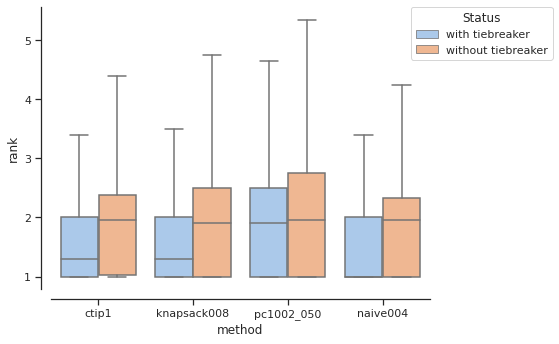

mean  median  count       std
method      label                                                
ctip1       with tiebreaker     1.771690    1.30    355  1.155022
            without tiebreaker  2.167042    1.95    355  1.428231
knapsack008 with tiebreaker     1.811070    1.30    542  1.354982
            without tiebreaker  2.183118    1.90    542  1.644631
naive004    with tiebreaker     1.665979    1.00    194  1.121806
            without tiebreaker  2.179897    1.95    194  1.615432
pc1002_050  with tiebreaker     2.149352    1.90    849  1.693496
            without tiebreaker  2.348233    1.95    849  2.058381

In [67]:
sns.set_theme(style="ticks", palette="pastel")

# for equity_tiebreaker in equity_tiebreaker_list:
    # display(HTML("<h3>Tiebreaker: %s</h3>" % equity_tiebreaker))
    # mask = rank_results_df['method'] == equity_tiebreaker
df_tp = get_improvement_tp(rank_results_df, equity_tiebreaker_list)
fig, ax = plt.subplots(figsize=(6.8,5.2))
sns.boxplot(ax=ax, x="method", y="rank",
            hue="label",
            data=df_tp,
            showfliers = False)
sns.despine(offset=10, trim=False)
plt.legend(bbox_to_anchor=(.95, 1), loc=2, borderaxespad=0., title='Status')
plt.savefig('outputs/boxplot_simulations_tp.png')
plt.show()

display(df_tp.groupby(['method', 'label'])['rank'].agg(['mean', 'median', 'count', 'std']))

In [22]:
# ax = sns.histplot(x="rank", hue="focal", palette=["m", "g"],
#                   data=rank_results_df.groupby(['method', 'focal', 'studentno']).mean().loc['none'].reset_index())

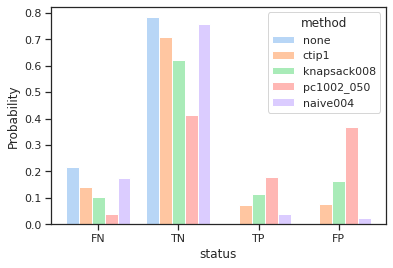

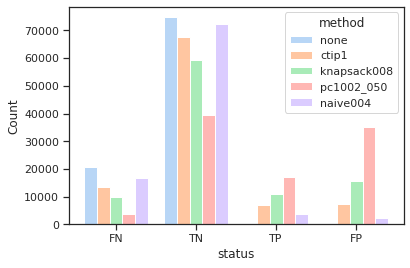

In [66]:
x_axis = tiebreaker_status
hue = "method"

ax = sns.histplot(x=x_axis, hue=hue, data=rank_results_df, multiple="dodge", shrink=.8, stat="probability", common_norm=False)
plt.savefig('outputs/tiebreaker_distribution_prob.png')
plt.show()

ax = sns.histplot(x=x_axis, hue=hue, data=rank_results_df, multiple="dodge", shrink=.8, common_norm=False)
plt.savefig('outputs/tiebreaker_distribution_count.png')
plt.show()

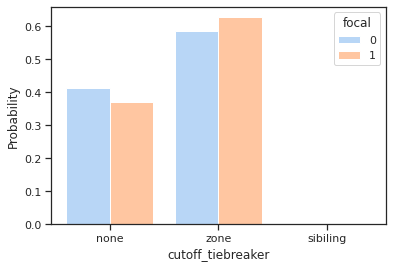

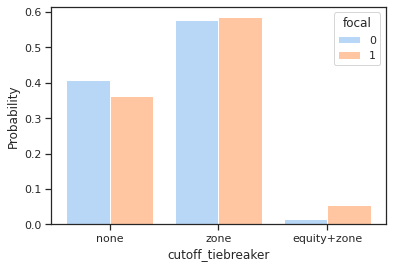

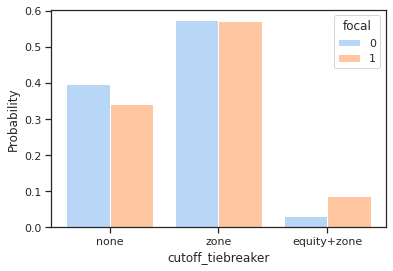

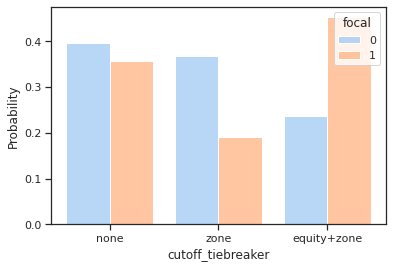

In [64]:
x_axis = "cutoff_tiebreaker"
hue = "focal"

for equity_tiebreaker in equity_tiebreaker_list:
    mask = rank_results_df['method'] == equity_tiebreaker
    display(HTML("<h3>Tiebreaker: %s</h3>" % equity_tiebreaker))
    ax = sns.histplot(x=x_axis, hue=hue, data=rank_results_df.loc[mask], multiple="dodge", shrink=.8, stat="probability", common_norm=False)
    plt.savefig('outputs/tiebreaker_distribution_%s.png' % equity_tiebreaker)
    plt.show()

# Regression Analysis

In [24]:
import statsmodels.api as sm

for equity_tiebreaker in equity_tiebreaker_list:
    mask = rank_results_df['method'] == equity_tiebreaker
    df = rank_results_df.loc[mask]
    df = pd.concat([df, pd.get_dummies(df[tiebreaker_status])], axis=1).groupby('studentno').mean()
    df = df.groupby('studentno').mean()
    # print(df)
    y = df['rank'].copy()
    x = df.copy().drop(columns=['iteration','rank', focal_block, 'focal'])
    # x = df[['focal']].copy()
    # x['const'] = 1.
    # corr = pd.DataFrame(x.corr(), columns=x.columns, index=x.columns)
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    # with sns.axes_style("white"):
    #     f, ax = plt.subplots(figsize=(7, 5))
    #     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)
    # plt.show()
    model = sm.OLS(y,x)
    results = model.fit()
    display(HTML("<h3>Tiebreaker: %s</h3>" % equity_tiebreaker))
    display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     330.3
Date:                Fri, 06 Aug 2021   Prob (F-statistic):          4.51e-135
Time:                        11:36:02   Log-Likelihood:                -14479.
No. Observations:                4772   AIC:                         2.896e+04
Df Residuals:                    4769   BIC:                         2.898e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Diversity_Category3    -2.1416      0.094    -22.793      0.000      -2.326      -1.957
FN                      5.9032      0.210     28.176      0.000       5.492       6.314
TN                      6.6785      0.116     57.802      0.000       6.452       6.905
==============================================================================
Omnibus:                     2871.061   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29252.771
Skew:                           2.765   Prob(JB):                         0.00
Kurtosis:                      13.796   Cond. No.                         4.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     154.3
Date:                Fri, 06 Aug 2021   Prob (F-statistic):          2.51e-124
Time:                        11:36:02   Log-Likelihood:                -14582.
No. Observations:                4772   AIC:                         2.917e+04
Df Residuals:                    4767   BIC:                         2.921e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Diversity_Category3    -1.9519      0.108    -18.141      0.000      -2.163      -1.741
FN                      5.6328      0.237     23.730      0.000       5.167       6.098
FP                      5.6543      0.342     16.546      0.000       4.984       6.324
TN                      6.6324      0.120     55.397      0.000       6.398       6.867
TP                      5.6285      0.346     16.274      0.000       4.950       6.306
==============================================================================
Omnibus:                     2895.574   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29118.461
Skew:                           2.804   Prob(JB):                         0.00
Kurtosis:                      13.724   Cond. No.                         8.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     171.9
Date:                Fri, 06 Aug 2021   Prob (F-statistic):          1.00e-137
Time:                        11:36:03   Log-Likelihood:                -14626.
No. Observations:                4772   AIC:                         2.926e+04
Df Residuals:                    4767   BIC:                         2.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Diversity_Category3    -1.6907      0.114    -14.815      0.000      -1.914      -1.467
FN                      5.4277      0.263     20.672      0.000       4.913       5.942
FP                      4.9191      0.266     18.521      0.000       4.398       5.440
TN                      6.7630      0.121     55.818      0.000       6.525       7.001
TP                      4.9907      0.310     16.124      0.000       4.384       5.597
==============================================================================
Omnibus:                     2832.890   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27705.052
Skew:                           2.733   Prob(JB):                         0.00
Kurtosis:                      13.463   Cond. No.                         7.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     185.4
Date:                Fri, 06 Aug 2021   Prob (F-statistic):          6.51e-148
Time:                        11:36:03   Log-Likelihood:                -14910.
No. Observations:                4772   AIC:                         2.983e+04
Df Residuals:                    4767   BIC:                         2.986e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Diversity_Category3    -0.8892      0.150     -5.918      0.000      -1.184      -0.595
FN                      5.1538      0.409     12.590      0.000       4.351       5.956
FP                      4.1085      0.257     15.976      0.000       3.604       4.613
TN                      7.2097      0.133     54.248      0.000       6.949       7.470
TP                      3.6839      0.321     11.472      0.000       3.054       4.313
==============================================================================
Omnibus:                     3301.245   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52923.912
Skew:                           3.153   Prob(JB):                         0.00
Kurtosis:                      18.047   Cond. No.                         7.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
def top3rank(x):
    return np.nanmean(x <= 3)
def countnan(x):
    return np.isnan(x).sum()

top3rank_pct = rank_results_df.groupby(['method', 'focal', 'iteration']).agg({'rank': top3rank})
top3rank_pct.groupby(['method', 'focal']).agg(['mean', 'std'])

rank          
                       mean       std
method      focal                    
ctip1       0      0.404293  0.003557
            1      0.543514  0.009560
knapsack008 0      0.404186  0.004430
            1      0.563504  0.005217
none        0      0.410832  0.004023
            1      0.513456  0.007240
pc1002_050  0      0.398181  0.004656
            1      0.563988  0.006394

# Save Assigment Summary

In [16]:
summary_df = summary_dict[equity_tiebreaker]
with pd.ExcelWriter("outputs/%s.xlsx" % equity_tiebreaker) as writer:  
    summary_df.to_excel(writer, sheet_name='raw')
    summary_df.groupby(group_columns).mean().to_excel(writer,
                                                      sheet_name='mean')
    summary_df.groupby(group_columns).std().to_excel(writer,
                                                      sheet_name='std')